<a href="https://colab.research.google.com/github/chuchun2/proj5_ams597/blob/edit_chuchun/GradientBoostedDecisionTree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import brier_score_loss
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set your directory
%cd /content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 5/Project 5 

/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 5/Project 5


## Data pre-processing

In [6]:
# Read data
data = pd.read_csv('./data_clean.csv', index_col='date_time', parse_dates=True)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
data.columns

Index(['station_id', 'latitude', 'longitude', 'elevation', 'date_time.1',
       'wind_direction', 'wind_speed', 'current_wx1', 'current_wx2',
       'current_wx3', 'low_cloud_type', 'low_cloud_level', 'medium_cloud_type',
       'medium_cloud_level', 'high_cloud_type', 'high_cloud_level',
       'highest_cloud_type', 'highest_cloud_level', 'cloud_coverage',
       'air_temperature', 'dew_point_temperature', 'altimeter',
       'present_weather', 'past_weather', 'past_weather2',
       'air_pressure_at_sea_level', 'eastward_wind', 'northward_wind'],
      dtype='object')

In [0]:
# Drop NaNs or constants
data.drop(columns = ['date_time.1', 'station_id', 'latitude', 'longitude', 'elevation', 'current_wx2', 'current_wx3', 'air_pressure_at_sea_level'], inplace = True)

In [9]:
# Unique weather symbols
data['current_wx1'].unique()

array(['BR', 'HZ', '-RA', '-FZRA', '-SN', 'SN', 'FG', 'RA', 'FZFG', '+SN',
       '+RA', '+TSRA', 'TSRA', '-TSRA', 'FZRA', 'BL', 'TS', '-SNRA',
       'VCTS', '+TS', '-TS', 'MIFG', '-SH', 'FZDZ'], dtype=object)

In [10]:
# Unique weather codes
data['present_weather'].unique()

array([10,  5, 61, 66, 71, 73, 45, 63, 49, 75, 65, 97, 95, 67,  0, 17, 68,
       13, 12, 80, 57])

In [0]:
# Choose classifications: 0 for liquid precipitation (rain, feezing rain, thunderstorm + rain, showers, freezing drizzle); 1 for solid (snow)
# METAR info here: https://en.wikipedia.org/wiki/METAR
wx_to_prcp = {'RA' : 0, '-RA' : 0, '+RA' : 0, 'FZRA' : 0, '-FZRA' : 0, '+FZRA' : 0, 'SN' : 1, '-SN' : 1, '+SN' : 1, 'TSRA' : 0, '-TSRA' : 0, '+TSRA' : 0}

In [0]:
# Simple dictionary lookup to classify weather symbols
def classify_prcp(wx_code):
    try:
        return wx_to_prcp[wx_code]
    except:
        return np.NaN    

In [0]:
# Apply to data
data['prcp_type'] = data['current_wx1'].apply(classify_prcp)

In [0]:
# Filter for precipitating observations
data = data.dropna(subset = ['prcp_type'])

In [0]:
# One-hot encoding for dates
data['month'] = data.index.month
data['day'] = data.index.day
data['hour'] = data.index.hour

In [16]:
data.head()

,wind_direction,wind_speed,current_wx1,low_cloud_type,low_cloud_level,medium_cloud_type,medium_cloud_level,high_cloud_type,high_cloud_level,highest_cloud_type,highest_cloud_level,cloud_coverage,air_temperature,dew_point_temperature,altimeter,present_weather,past_weather,past_weather2,eastward_wind,northward_wind,prcp_type,month,day,hour
date_time,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-02 01:25:00,90.0,12.0,-RA,SCT,7000.0,OVC,8500.0,NaN,NaN,NaN,NaN,8,3.0,1.0,29.79,61,0,0,-12.000000,-7.347881e-16,0.0,1,2,1
2000-01-02 01:30:00,90.0,13.0,-RA,OVC,7500.0,NaN,NaN,NaN,NaN,NaN,NaN,8,3.0,1.0,29.79,61,0,0,-13.000000,-7.960204e-16,0.0,1,2,1
2000-01-02 01:35:00,100.0,10.0,-RA,OVC,8000.0,NaN,NaN,NaN,NaN,NaN,NaN,8,3.0,1.0,29.80,61,0,0,-9.848078,1.736482e+00,0.0,1,2,1
2000-01-02 04:10:00,80.0,11.0,-RA,FEW,6000.0,OVC,8500.0,NaN,NaN,NaN,NaN,8,4.0,2.0,29.73,61,0,0,-10.832885,-1.910130e+00,0.0,1,2,4
2000-01-02 04:15:00,90.0,14.0,-RA,FEW,6000.0,OVC,8000.0,NaN,NaN,NaN,NaN,8,4.0,2.0,29.73,61,0,0,-14.000000,-8.572528e-16,0.0,1,2,4


## Logistic Regression Model

In [0]:
# Choose features - this could be updated later
data = data.filter(['wind_direction', 'wind_speed',
                    'low_cloud_level', 'low_cloud_type', 'cloud_coverage', # Medium or high cloud data contains many many NaNs
                    'air_temperature', 'dew_point_temperature', 
                    'altimeter', 'eastward_wind', 'northward_wind',
                    'month', 'day', 'hour',
                    'prcp_type']).dropna()

In [0]:
# One-hot encoding for cloud type
data = pd.get_dummies(data)

In [0]:
# Separate labels
labels = data['prcp_type'].to_numpy()
features = data.drop(columns = ['prcp_type']).to_numpy()

In [0]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 42)

In [21]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (78136, 17)
Training Labels Shape: (78136,)
Testing Features Shape: (33488, 17)
Testing Labels Shape: (33488,)


In [22]:
# Train the model!
clf = LogisticRegression(max_iter=10e10, random_state=42)
clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000000000.0,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# How well did we do?
print('Training data score: ' + str(clf.score(train_features, train_labels)))
print('Testing data score: ' + str(clf.score(test_features, test_labels)))

Training data score: 0.9552319033480086
Testing data score: 0.9554168657429527


## Gradient-Boosted Decision Tree

In [24]:
# Gradient Boosting for classification
# gb_clf = GradientBoostingClassifier(n_estimators=1000)
gb_clf = GradientBoostingClassifier(n_estimators=400, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=None)

# Train the model with training set
gb_clf.fit(train_features, train_labels)

# Score
print('Training data score: ' + str(gb_clf.score(train_features, train_labels)))
print('Testing data score: ' + str(gb_clf.score(test_features, test_labels)))

# Brier score
print('Training Brier score: ' + str(brier_score_loss(train_labels, gb_clf.predict(train_features))))
print('Testing Brier score: ' + str(brier_score_loss(test_labels, gb_clf.predict(test_features))))

Training data score: 0.9997952288317805
Testing data score: 0.9957895365504061
Training Brier score: 0.0002047711682195147
Testing Brier score: 0.004210463449593884


### Hyperparameter Tuning

In [25]:
# Using Random Search Cross Validation in Scikit-Learn
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(gb_clf.get_params())

Parameters currently in use:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 400,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [26]:
# Optimizing with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
# Number of trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [5, 8, 15, 25, 30]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
pprint(random_grid)

{'max_depth': [5, 8, 15, 25, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
gb_clf_base = GradientBoostingClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_clf_random = RandomizedSearchCV(estimator = gb_clf_base, param_distributions = random_grid, 
                                    n_iter = 10, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)

# Fit the random search model
gb_clf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 41.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [28]:
# Best parameters from fitting the random search
gb_clf_random.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 800}

### Optimized Hyperparameter

In [29]:
# Gradient Boosting for classification
gb_clf_best = GradientBoostingClassifier(n_estimators=gb_clf_random.best_params_['n_estimators'], 
                                         min_samples_split=gb_clf_random.best_params_['min_samples_split'], 
                                         min_samples_leaf=gb_clf_random.best_params_['min_samples_leaf'], 
                                         max_features=gb_clf_random.best_params_['max_features'], 
                                         max_depth=gb_clf_random.best_params_['max_depth'])
# gb_clf_best = GradientBoostingClassifier(n_estimators=600, min_samples_split=10, min_samples_leaf=2, max_features='sqrt', max_depth=25)

# Train the model with training set
gb_clf_best.fit(train_features, train_labels)

# Score
print('Training data score: ' + str(gb_clf_best.score(train_features, train_labels)))
print('Testing data score: ' + str(gb_clf_best.score(test_features, test_labels)))

# Brier score
print('Training Brier score: ' + str(brier_score_loss(train_labels, gb_clf_best.predict(train_features))))
print('Testing Brier score: ' + str(brier_score_loss(test_labels, gb_clf_best.predict(test_features))))

Training data score: 0.9997952288317805
Testing data score: 0.9960881509794554
Training Brier score: 0.0002047711682195147
Testing Brier score: 0.003911849020544673


[[20026    92]
 [   39 13331]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


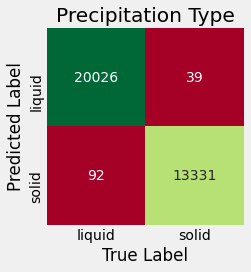

In [30]:
mat = confusion_matrix(test_labels, gb_clf_best.predict(test_features))
print(mat)

# Plot matrix
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
mpl.style.use('fivethirtyeight')

labels_str = ['liquid', 'solid']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=labels_str, yticklabels=labels_str, cmap='RdYlGn')
plt.title('Precipitation Type')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.tight_layout()
plt.savefig('./gb_clf_best_conf_mat.png', dpi=600)

In [0]:
# Probabilities for logistic regression
train_prob = gb_clf_best.predict_proba(train_features)
test_prob = gb_clf_best.predict_proba(test_features)

In [0]:
# Climatological probability
def get_climo(labels, shape):
    climo = (np.size((labels == 1).nonzero()))/float(np.size(labels))
    prob  = np.zeros((shape))
    prob[:,0] = 1-climo
    prob[:,1] = climo

    return prob

In [0]:
# Calculate climatological probability for training and testing data
train_climo_prob = get_climo(train_labels, train_prob.shape)
test_climo_prob = get_climo(test_labels, test_prob.shape)

In [0]:
# Calculate the Brier Skill Score
train_bss = 1 - (brier_score_loss(train_labels, train_prob[:,1])/brier_score_loss(train_labels, train_climo_prob[:,1]))
test_bss = 1 - (brier_score_loss(test_labels, test_prob[:,1])/brier_score_loss(test_labels, test_climo_prob[:,1]))

In [35]:
# Bier skill score (USE THIS ONE!!)
print('Training Brier Skill Score: ' + str(train_bss))
print('Testing Brier Skill Score: ' + str(test_bss))

Training Brier Skill Score: 0.9995734097744778
Testing Brier Skill Score: 0.9845175465157162
